# Principal Component Analysis (PCA)

PCA finds the directions in your data where the points are most spread out (maximum variance), allowing you to summarize high-dimensional data using just a few key axes of variation.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide31.png)

# Key Formula

Let $\mathbf{X}$ be an $n \times p$ data matrix (n observations, p variables). PCA finds new axes by eigenvalue decomposition of the covariance matrix:

$$
\mathbf{\Sigma} = \mathbf{V\Lambda V}^T
$$

where:
- $\mathbf{\Sigma} = \frac{1}{n-1}\mathbf{X}^T\mathbf{X}$ is the $p \times p$ covariance matrix (assuming $\mathbf{X}$ is centered)
- $\mathbf{V}$ is the $p \times p$ matrix of **eigenvectors** (principal component directions)
- $\mathbf{\Lambda}$ is the $p \times p$ diagonal matrix of **eigenvalues** (variance explained by each PC)

# Technical Details

## PC scores

The principal component scores are obtained by projecting the data onto the eigenvectors:

$$
\mathbf{Z} = \mathbf{XV}
$$

where $\mathbf{Z}$ is the $n \times p$ matrix of principal component scores.

**Intuition:** PCA finds directions (eigenvectors) where the data varies the most (eigenvalues).

## Variance Explained

The proportion of variance explained by the $k$-th principal component is:

$$
\frac{\lambda_k}{\sum_{j=1}^p \lambda_j}
$$

where $\lambda_k$ is the $k$-th eigenvalue. The cumulative proportion of variance explained by the first $k$ PCs is:

$$
\frac{\sum_{j=1}^k \lambda_j}{\sum_{j=1}^p \lambda_j}
$$

## Dimensionality Reduction

To reduce from $p$ dimensions to $k$ dimensions (where $k < p$), use only the first $k$ eigenvectors:

$$
\mathbf{Z}_k = \mathbf{XV}_k
$$

where $\mathbf{V}_k$ contains the first $k$ columns of $\mathbf{V}$ (corresponding to the $k$ largest eigenvalues), and $\mathbf{Z}_k$ is $n \times k$.

- **Choosing the Number of Components**:
  1. **Scree plot**: Look for "elbow" where eigenvalues level off
  2. **Kaiser criterion**: Keep components with $\lambda_k > 1$ (for correlation matrix)
  3. **Cumulative variance**: Keep enough components to explain a target percentage (e.g., 80-90%)
  4. **Cross-validation**: Choose $k$ that minimizes prediction error


## Singular Value Decomposition (SVD)

PCA can also be computed via SVD of the centered data matrix:

$$
\mathbf{X} = \mathbf{U\Sigma V}^T
$$

where:
- $\mathbf{U}$ is $N \times N$ (left singular vectors)
- $\mathbf{\Sigma}$ is $N \times p$ (diagonal matrix of singular values)
- $\mathbf{V}$ is $p \times p$ (right singular vectors = principal component directions)

The principal component scores are: $\mathbf{Z} = \mathbf{U\Sigma}$

The eigenvalues are related to singular values by: $\lambda_j = \frac{\sigma_j^2}{n-1}$

## Properties of PCA

1. **Orthogonality**: Principal components are uncorrelated ($\mathbf{V}^T\mathbf{V} = \mathbf{I}$)
2. **Variance maximization**: PC1 has maximum variance, PC2 has maximum variance orthogonal to PC1, etc.
3. **Optimal reconstruction**: For fixed $k$, PCA minimizes reconstruction error
4. **Linear transformation**: PCs are linear combinations of original variables
5. **Deterministic**: Same data always produces same PCs (up to sign)

# Related Topics

- [Confounders](https://statfungen.github.io/statgen-prerequisites/confounder.html)
- [Genetic Relationship Matrix](https://statfungen.github.io/statgen-prerequisites/genetic_relationship_matrix.html)
- [Proportion of Variance Explained](https://statfungen.github.io/statgen-prerequisites/proportion_of_variance_explained.html)
- [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html)

# Example

## Detecting Population Substructure with PCA

Say you've recruited 30 individuals for a genetic study, but ancestry information is incomplete or unreliable (some said "unknown," others prefer not to say).

**The Question:** Does your sample contain hidden population substructure that could confound your results? Are individuals genetically homogenous or are there distinct groups?

**Why This Matters:** Undetected population stratification can lead to spurious associations in downstream analyses. PCA is a critical first step in quality control.

In this example we use PCA to reveal genetic ancestry structure directly from the data, without relying on self-report, and identify which individuals cluster together and which might be outliers.

In [1]:
# Clear the environment
rm(list = ls())
set.seed(42)

# Create synthetic genotype data
# Simulate data from 30 individuals at 100 variants
# with structure from 3 populations that are more mixed

n_individuals <- 30
n_variants <- 100

# Create population labels
# Group 1: 10 individuals from one ancestry
# Group 2: 10 individuals from another ancestry  
# Group 3: 10 individuals from a third ancestry
population <- c(rep("Pop1", 20), rep("Pop2", 10))

# Generate genotype data with population structure but more overlap
# Population 1: moderate allele frequencies
# Population 2: different allele frequencies
X_pop1 <- matrix(rbinom(20 * n_variants, size = 2, prob = 0.3), 
                  nrow = 20, ncol = n_variants)
X_pop2 <- matrix(rbinom(10 * n_variants, size = 2, prob = 0.1), 
                  nrow = 10, ncol = n_variants)

# Combine the two populations
X <- rbind(X_pop1, X_pop2)
rownames(X) <- paste("Individual", 1:n_individuals, sep = "_")
colnames(X) <- paste("Variant", 1:n_variants, sep = "_")

cat("Data dimensions:", nrow(X), "individuals x", ncol(X), "variants\n")
cat("Population labels:", table(population), "\n")

Data dimensions: 30 individuals x 100 variants
Population labels: 20 10 


As we did in the [Genotype Coding](https://statfungen.github.io/statgen-prerequisites/genotype_coding.html), we first standardize the genotype matrix by centering and scaling each variant so they have mean 0 and standard deviation 1.

In [2]:
# Standardize the data matrix
X_std <- scale(X, center = TRUE, scale = TRUE)

### Compute PCA

Now we perform PCA on the standardized data using eigendecomposition of the covariance matrix.

In [3]:
# Compute PCA using eigendecomposition (base R)
# This implements PCA from first principles

# Step 1: Compute the covariance matrix
cov_matrix <- cov(X_std)

# Step 2: Perform eigendecomposition
eigen_result <- eigen(cov_matrix)
eigenvalues <- eigen_result$values
eigenvectors <- eigen_result$vectors

# Step 3: Compute PC scores by projecting data onto eigenvectors
PC_scores <- X_std %*% eigenvectors

# Step 4: Compute variance explained
variance_explained <- (eigenvalues / sum(eigenvalues)) * 100

# Extract loadings (eigenvectors)
PC_loadings <- eigenvectors

cat("Variance explained by top 5 PCs:\n")
print(round(variance_explained[1:5], 2))

cat("\nCumulative variance explained by top 5 PCs:\n")
print(round(cumsum(variance_explained[1:5]), 2))

Variance explained by top 5 PCs:
[1] 13.60  7.79  6.67  6.32  5.98

Cumulative variance explained by top 5 PCs:
[1] 13.60 21.39 28.06 34.38 40.36


### Interpret the Results

Let's examine the first two principal components, which typically capture the major patterns in genomic data.

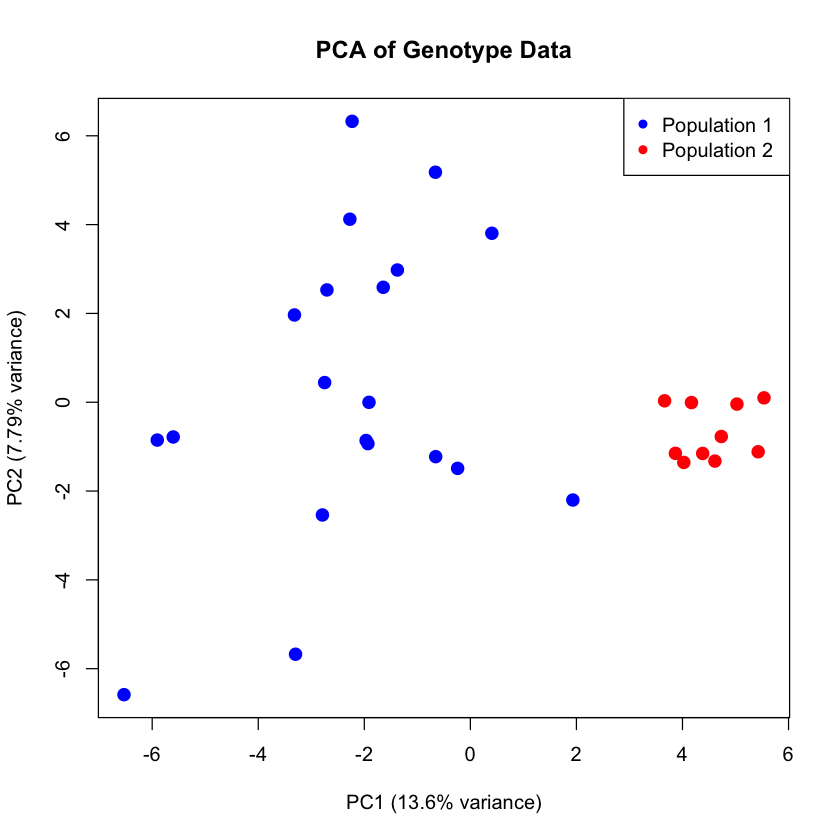

In [4]:
# Extract first two PCs
PC1 <- PC_scores[, 1]
PC2 <- PC_scores[, 2]

# Create a scatter plot
plot(PC1, PC2, 
     col = ifelse(population == "Pop1", "blue", "red"),
     pch = 16, 
     main = "PCA of Genotype Data",
     xlab = paste0("PC1 (", round(variance_explained[1], 2), "% variance)"),
     ylab = paste0("PC2 (", round(variance_explained[2], 2), "% variance)"),
     cex = 1.5)

# Add legend
legend("topright", 
       legend = c("Population 1", "Population 2"),
       col = c("blue", "red"),
       pch = 16)

### Variance Explained

A scree plot shows how much variance each principal component explains. This helps us decide how many PCs to retain for downstream analyses.

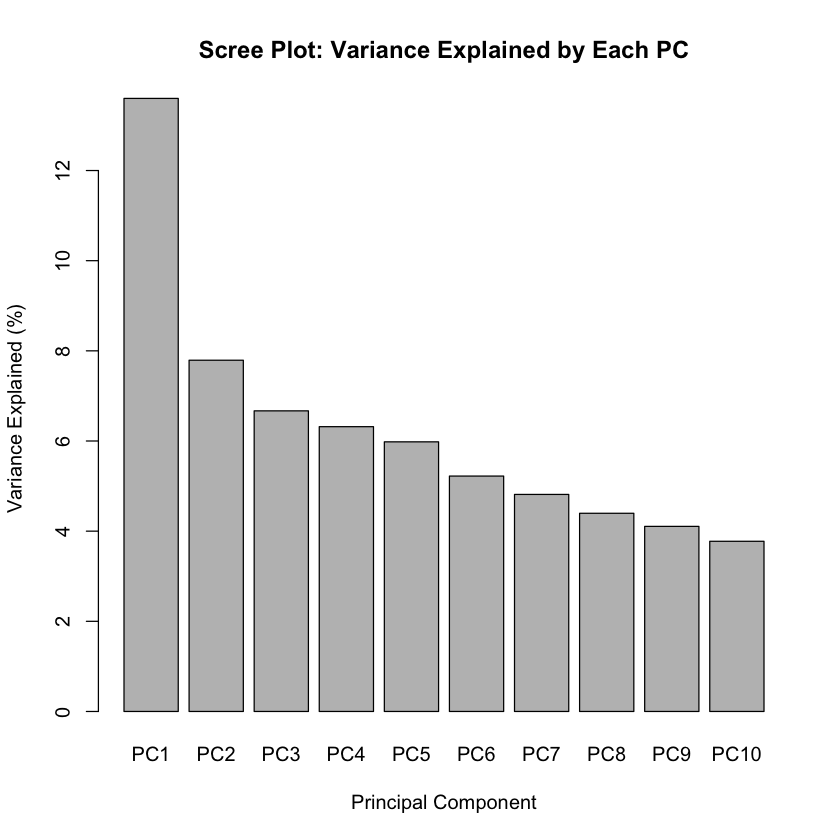

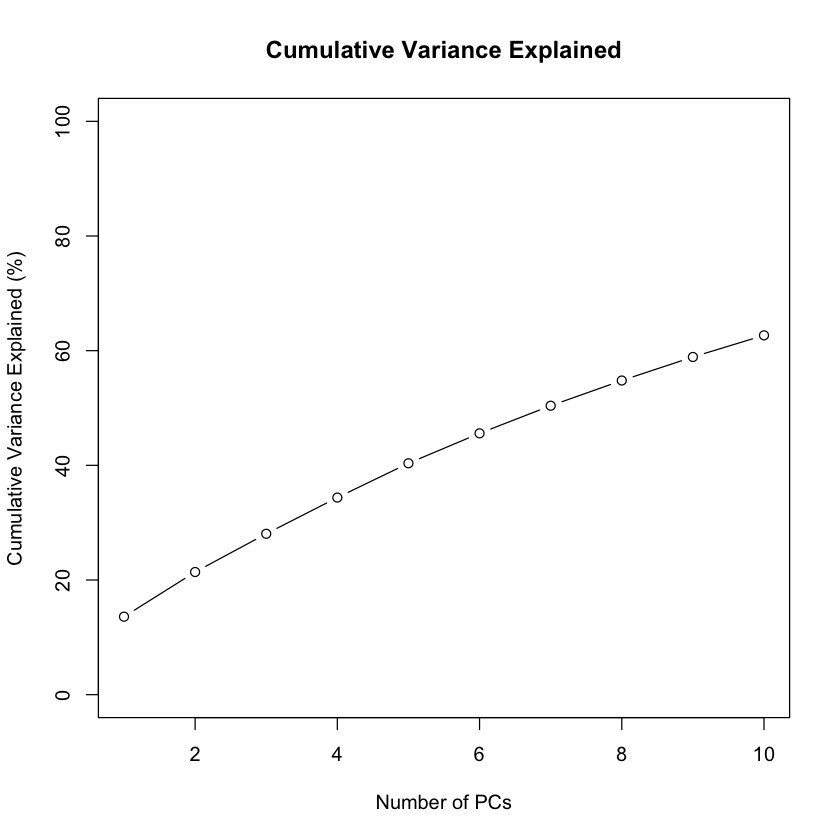

In [5]:
# Create a scree plot
barplot(variance_explained[1:10], 
        names.arg = paste0("PC", 1:10),
        main = "Scree Plot: Variance Explained by Each PC",
        xlab = "Principal Component",
        ylab = "Variance Explained (%)")

# Create a cumulative variance plot
plot(cumsum(variance_explained[1:10]), 
     type = "b",
     main = "Cumulative Variance Explained",
     xlab = "Number of PCs",
     ylab = "Cumulative Variance Explained (%)",
     ylim = c(0, 100))

### Examine PC Loadings

PC loadings tell us which variants contribute most to each principal component. Variants with high loadings drive the separation between populations.

Top 10 variants contributing to PC1:
 [1] -0.1864147 -0.1777824 -0.1750879 -0.1745686 -0.1682217 -0.1672700
 [7] -0.1540772 -0.1536602 -0.1534139 -0.1528922


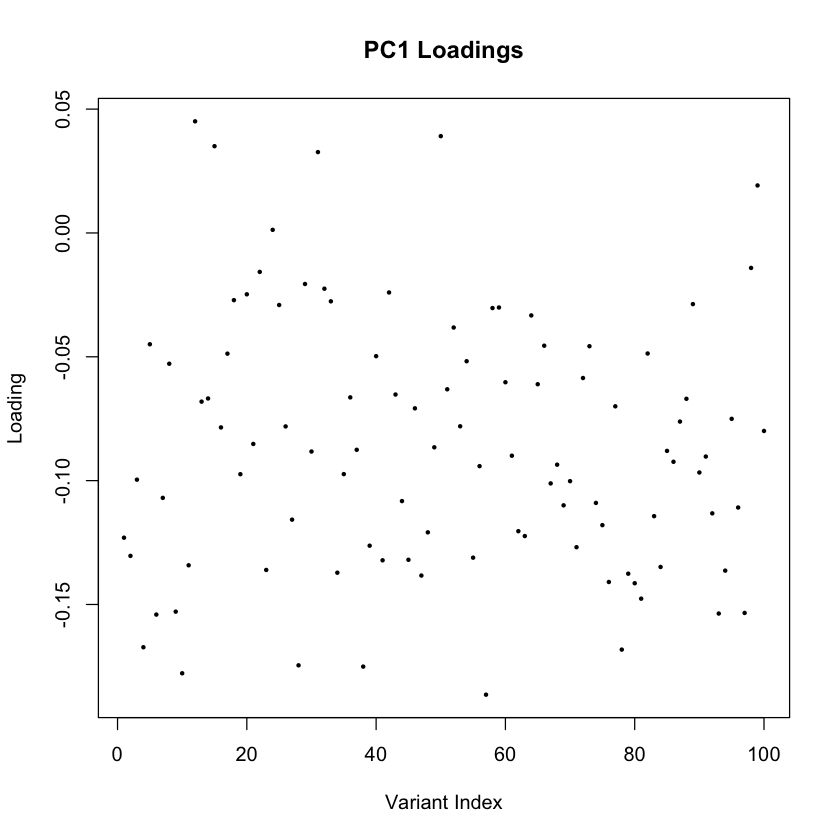

In [6]:
# Get the top variants contributing to PC1
PC1_loadings <- PC_loadings[, 1]

# Find variants with highest absolute loadings
top_indices <- order(abs(PC1_loadings), decreasing = TRUE)[1:10]

cat("Top 10 variants contributing to PC1:\n")
print(PC1_loadings[top_indices])

# Create a loadings plot
plot(PC1_loadings, 
     main = "PC1 Loadings",
     xlab = "Variant Index",
     ylab = "Loading",
     pch = 16,
     cex = 0.5)

## Example 2: Admixture Analysis

Admixture analysis identifies ancestry components in individuals from genetically mixed populations. When populations with distinct genetic backgrounds interbreed over generations, their descendants carry genetic variants from multiple ancestral sources. 

In this example, we'll demonstrate how factor analysis can be applied to genetic admixture analysis. We'll simulate genotype data for individuals with ancestry from three source populations (European, West African, and East Asian), then use factor analysis to:
1. Identify the number of ancestral populations
2. Estimate individual ancestry proportions (factor scores)
3. Identify ancestry-informative markers (factor loadings)

This setup is the same example as we did in [Factor Analysis](https://statfungen.github.io/statgen-prerequisites/factor_analysis.html) and now we see how PCA solves this.

### Simulate Admixed Genotype Data

We'll create synthetic genotype data where we know the true ancestral populations and individual ancestry proportions.

In [27]:
rm(list=ls())
# Load additional libraries for admixture example
library(RColorBrewer)
library(psych)

set.seed(51)

# ============================================================
# Define ancestral population allele frequencies
# ============================================================

n_snps <- 50        # Number of SNPs
n_individuals <- 100 # Number of admixed individuals
K <- 3               # Number of ancestral populations

# Ancestral allele frequencies for each population
ancestral_freq <- matrix(0, nrow = n_snps, ncol = K)

# Population 1 (European-like): moderate frequencies
ancestral_freq[, 1] <- rbeta(n_snps, 2, 2)

# Population 2 (African-like): some SNPs differentiated from Pop 1
ancestral_freq[, 2] <- rbeta(n_snps, 2, 2)
high_diff_idx1 <- sample(1:n_snps, 0.3*n_snps)
ancestral_freq[high_diff_idx1, 2] <- ancestral_freq[high_diff_idx1, 2] * 0.3 + 0.6

# Population 3 (Asian-like): differentiated from both Pop 1 and 2
ancestral_freq[, 3] <- rbeta(n_snps, 2, 2)
high_diff_idx2 <- sample(setdiff(1:n_snps, high_diff_idx1), 0.3*n_snps)
ancestral_freq[high_diff_idx2, 3] <- 1 - ancestral_freq[high_diff_idx2, 3] * 0.5

# Ensure frequencies are in [0,1]
ancestral_freq <- pmin(pmax(ancestral_freq, 0.05), 0.95)

# Generate individual ancestry proportions using Dirichlet distribution
# Group 1: Mostly European (n=30)
ancestry_group1 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(8, 1, 1))
  ancestry_group1[i, ] <- props / sum(props)
}

# Group 2: Mostly African (n=30)
ancestry_group2 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(1, 8, 1))
  ancestry_group2[i, ] <- props / sum(props)
}

# Group 3: Mostly Asian (n=30)
ancestry_group3 <- matrix(0, nrow = 30, ncol = K)
for (i in 1:30) {
  props <- rgamma(K, c(1, 1, 8))
  ancestry_group3[i, ] <- props / sum(props)
}

# Group 4: Admixed (n=10)
ancestry_group4 <- matrix(0, nrow = 10, ncol = K)
for (i in 1:10) {
  props <- rgamma(K, c(2, 2, 2))
  ancestry_group4[i, ] <- props / sum(props)
}

# Combine all groups
true_ancestry <- rbind(ancestry_group1, ancestry_group2, ancestry_group3, ancestry_group4)
colnames(true_ancestry) <- c("European", "African", "Asian")

Now we simulate the genotypes based on the admixture model and standardize the matrix:

In [29]:
# ============================================================
# Simulate genotypes based on admixture model
# ============================================================

# Genotype matrix: rows = individuals, columns = SNPs
genotypes <- matrix(0, nrow = n_individuals, ncol = n_snps)

for (i in 1:n_individuals) {
  for (j in 1:n_snps) {
    # Calculate admixed allele frequency for this individual at this SNP
    admixed_freq <- sum(true_ancestry[i, ] * ancestral_freq[j, ])
    
    # Sample genotype (0, 1, or 2 copies of reference allele)
    genotypes[i, j] <- rbinom(1, size = 2, prob = admixed_freq)
  }
}

# Standardize genotypes (center and scale each SNP)
genotypes_std <- scale(genotypes, center = TRUE, scale = TRUE)

### Perform PCA

In [30]:
# ============================================================
# Perform PCA to detect ancestry structure
# ============================================================

cat("\n============================================\n")
cat("Performing PCA on genotype data\n")
cat("============================================\n\n")

# Perform PCA on standardized genotypes
pca_result <- prcomp(genotypes_std, center = FALSE, scale. = FALSE)

# Extract PC scores for each individual
pc_scores <- pca_result$x

# Calculate variance explained by each PC
variance_explained <- (pca_result$sdev^2) / sum(pca_result$sdev^2) * 100

cat("Variance explained by top 5 PCs:\n")
for (i in 1:5) {
  cat(sprintf("PC%d: %.2f%%\n", i, variance_explained[i]))
}
cat("\n")


Performing PCA on genotype data

Variance explained by top 5 PCs:
PC1: 12.10%
PC2: 6.44%
PC3: 4.66%
PC4: 4.40%
PC5: 4.31%



### Visualization

In [31]:
# Define group labels for plotting
group_labels <- c(rep("Predominantly European", 30),
                  rep("Predominantly African", 30),
                  rep("Predominantly Asian", 30),
                  rep("Admixed", 10))

# Define colors for each group
group_colors <- c("Predominantly European" = "#E41A1C",
                  "Predominantly African" = "#377EB8",
                  "Predominantly Asian" = "#4DAF4A",
                  "Admixed" = "#984EA3")

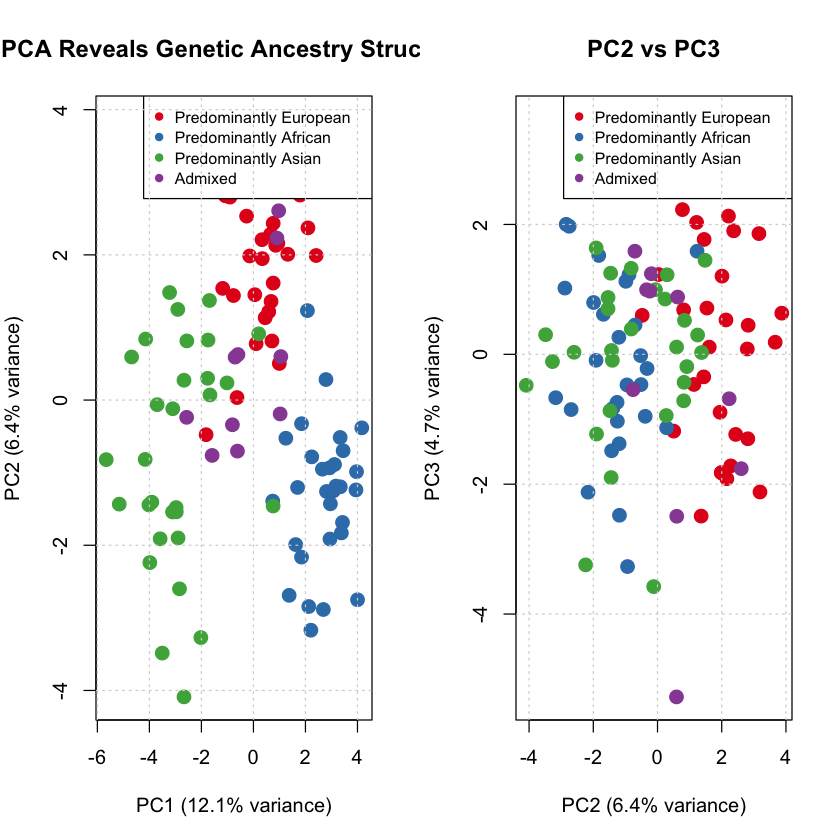

In [32]:
# ============================================================
# Visualization 1: PC1 vs PC2 scatter plot
# ============================================================

par(mfrow = c(1, 2), mar = c(5, 4, 4, 2))

# PC1 vs PC2
plot(pc_scores[, 1], pc_scores[, 2],
     col = group_colors[group_labels],
     pch = 19, cex = 1.5,
     xlab = sprintf("PC1 (%.1f%% variance)", variance_explained[1]),
     ylab = sprintf("PC2 (%.1f%% variance)", variance_explained[2]),
     main = "PCA Reveals Genetic Ancestry Structure")
legend("topright", legend = names(group_colors),
       col = group_colors, pch = 19, cex = 0.8)
grid()

# PC2 vs PC3
plot(pc_scores[, 2], pc_scores[, 3],
     col = group_colors[group_labels],
     pch = 19, cex = 1.5,
     xlab = sprintf("PC2 (%.1f%% variance)", variance_explained[2]),
     ylab = sprintf("PC3 (%.1f%% variance)", variance_explained[3]),
     main = "PC2 vs PC3")
legend("topright", legend = names(group_colors),
       col = group_colors, pch = 19, cex = 0.8)
grid()

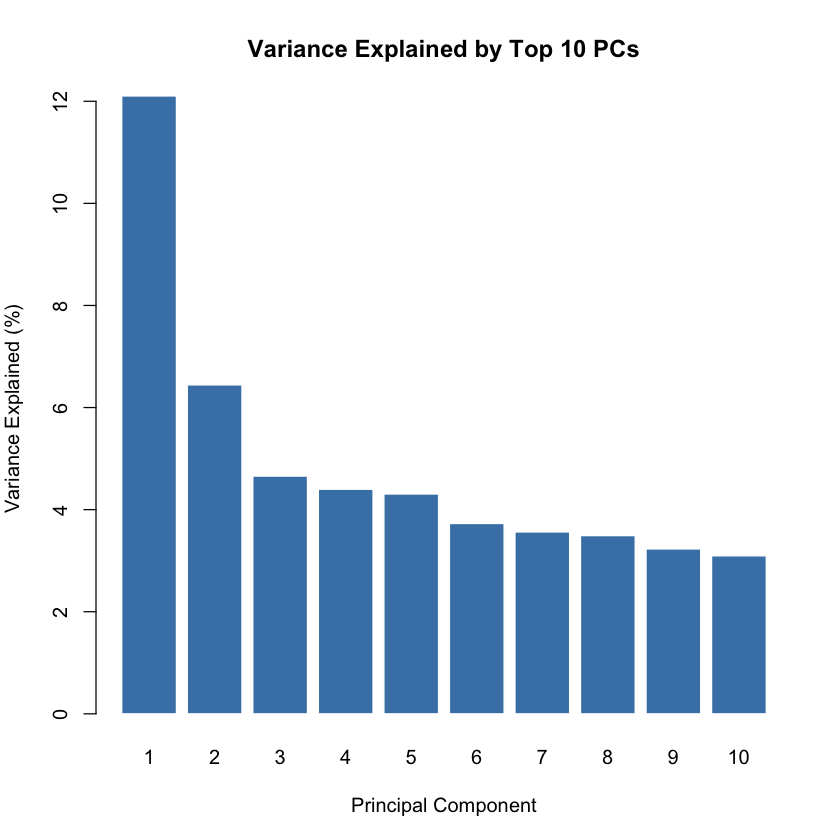

In [33]:
# ============================================================
# Visualization 2: Variance explained barplot
# ============================================================

par(mfrow = c(1, 1), mar = c(5, 4, 4, 2))
barplot(variance_explained[1:10],
        names.arg = 1:10,
        xlab = "Principal Component",
        ylab = "Variance Explained (%)",
        main = "Variance Explained by Top 10 PCs",
        col = "steelblue",
        border = "white")


In [34]:
# ============================================================
# Compare PCA-inferred structure to true ancestry
# ============================================================

cat("\n============================================\n")
cat("Comparing PCA results to true ancestry\n")
cat("============================================\n\n")

# The PC scores capture ancestry structure
# Let's correlate PC1-3 with true ancestry proportions
correlations <- cor(pc_scores[, 1:3], true_ancestry)

cat("Correlation between PC scores and true ancestry proportions:\n")
round(correlations, 3)
cat("\n")


Comparing PCA results to true ancestry

Correlation between PC scores and true ancestry proportions:


,European,African,Asian
PC1,0.091,0.743,-0.849
PC2,0.803,-0.476,-0.318
PC3,0.051,-0.039,-0.011


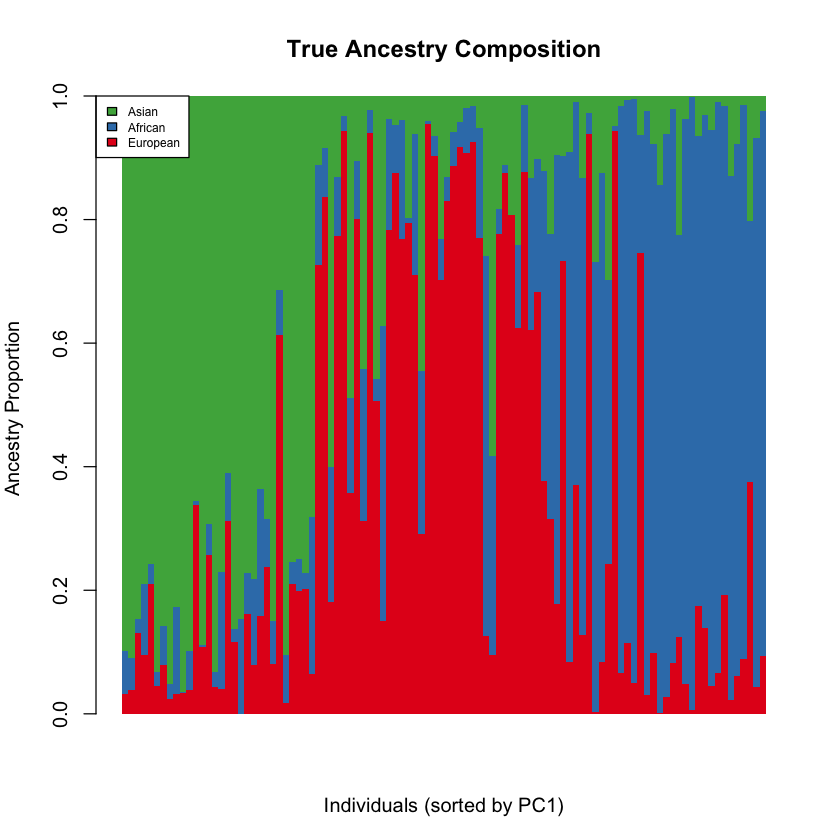

In [40]:
# ============================================================
# Visualization 3: Structure-like plot
# ============================================================

# Sort individuals by PC1 for better visualization
sort_idx <- order(pc_scores[, 1])

par(mar = c(5, 4, 4, 2))
barplot(t(true_ancestry[sort_idx, ]),
        col = c("#E41A1C", "#377EB8", "#4DAF4A"),
        border = NA,
        space = 0,
        xlab = "Individuals (sorted by PC1)",
        ylab = "Ancestry Proportion",
        main = "True Ancestry Composition",
        legend.text = colnames(true_ancestry),
        args.legend = list(x = "topleft", cex = 0.6))

# Supplementary

## Comparison With Factor Analysis

| Aspect | PCA | Factor Analysis |
|--------|-----|-----------------|
| **Goal** | Reduce dimensions, summarize data | Explain correlations via latent factors |
| **Model** | $\mathbf{X} = \mathbf{ZV}^T$ (no error term) | $\mathbf{X} = \mathbf{LF} + \mathbf{E}$ (explicit error) |
| **Causality** | Observed variables → Components | Latent factors → Observed variables |
| **What it finds** | Directions of maximum variance | Hidden causes of correlations |
| **Variance explained** | Total variance | Common variance only (excludes uniqueness) |
| **Rotation** | No rotation | Essential for interpretation (EFA) |
| **Component/Factor order** | Ordered by variance explained | No natural ordering (until rotated) |
| **Interpretation** | "Axes of variation" | "Latent constructs" (must be named) |
| **Deterministic** | Yes (unique solution) | No (requires rotation for uniqueness) |
| **Use case** | Visualization, dimension reduction | Identify underlying constructs/pathways |
| **Genetics example** | Population structure plots, GWAS covariates | Gene expression pathways (rarely on genotypes) |

## Graphical Summary

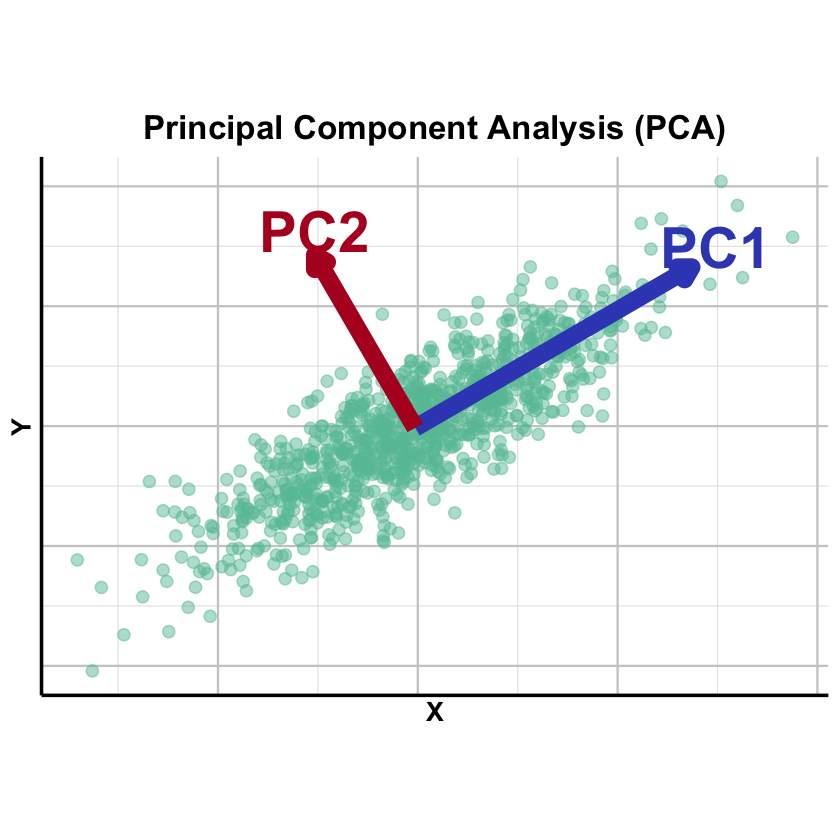

In [85]:
library(ggplot2)

# Set seed for reproducibility
set.seed(42)

# Generate correlated 2D data with PC1 >> PC2
n <- 1000
theta <- pi/6  # 30 degree tilt

# Create elongated cloud - PC1 much longer than PC2
x <- rnorm(n, 0, 3)    # Large variance for PC1 direction
y <- rnorm(n, 0, 0.8)  # Small variance for PC2 direction

# Rotate to create diagonal spread
X_original <- x * cos(theta) - y * sin(theta)
Y_original <- x * sin(theta) + y * cos(theta)

data <- data.frame(X = X_original, Y = Y_original)

# Perform PCA
pca <- prcomp(data, center = TRUE, scale. = FALSE)

# Get PC directions (eigenvectors) - flip if needed
pc1_direction <- -pca$rotation[, 1]  
pc2_direction <- -pca$rotation[, 2]  

# Scale for visualization
scale_factor1 <- 8
scale_factor2 <- 5
pc1_end <- scale_factor1 * pc1_direction
pc2_end <- scale_factor2 * pc2_direction

# Get the center (mean)
center_x <- mean(X_original)
center_y <- mean(Y_original)

# Create the plot
p_PCA <- ggplot(data, aes(x = X, y = Y)) +
  geom_point(color = "#66C2A5", alpha = 0.5, size = 3) +
  
  # PC1 arrow (blue) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc1_end[1], 
           yend = center_y + pc1_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#3B4CC0", linewidth = 5) +
  annotate("text", x = center_x + pc1_end[1] + 0.6, 
           y = center_y + pc1_end[2] + 0.5, 
           label = "PC1", color = "#3B4CC0", size = 12, fontface = "bold") +
  
  # PC2 arrow (purple) - use annotate instead of geom_segment
  annotate("segment", 
           x = center_x, y = center_y, 
           xend = center_x + pc2_end[1], 
           yend = center_y + pc2_end[2],
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           color = "#B40426", linewidth = 5) +
  annotate("text", x = center_x + pc2_end[1], 
           y = center_y + pc2_end[2] + 0.6, 
           label = "PC2", color = "#B40426", size = 12, fontface = "bold") +
  
  # Styling
  labs(title = "Principal Component Analysis (PCA)",
       x = "X", y = "Y") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text = element_blank(),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_line(color = "gray90"),
    axis.line = element_line(color = "black", linewidth = 1),
    plot.background = element_rect(fill = "transparent", color = NA),
    panel.background = element_rect(fill = "transparent", color = NA)
  ) +
  coord_fixed(ratio = 1)
  
# Save with transparent background
ggsave("./cartoons/PCA.png", plot = p_PCA, width = 18, height = 12, 
       units = "in", dpi = 300, bg = "transparent")

print(p_PCA)